In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
from numpy import mean
from math import sqrt,acos,cos,sin,pi,exp,log,isnan,atan2
from numpy import asarray
from root_pandas import read_root
from matplotlib import gridspec
from scipy import stats
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from textwrap import wrap
import seaborn as sns

import os

from PlottingScripts import CV, Spline, Tune1, sampHist, distVar, distplot_wratio

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Welcome to JupyROOT 6.18/04


This notebook comprises various studies for specifically comparing two stacked MC histograms. It may not be up to date.

In [3]:
def mcmcplot(myvar,nbins,myrange,hists1,hists2,stxcoord,legpos=0,ymax=-1,fs=(16,11),normshift=1):

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)

    vals_h1 = np.zeros(nbins)
    vals_h1_raw = np.zeros(nbins)
    yerrsq_h1 = np.zeros(nbins)
    
    vals_h2 = np.zeros(nbins)
    vals_h2_raw = np.zeros(nbins)
    yerrsq_h2 = np.zeros(nbins)
    
    ndof = 0

    a_scaledweight = []
    a_labels_evts = []
    a_colors = []
    a_hists = []

    for hist in hists1:
        h1_raw,binedges = np.histogram(hist.dist(myvar),nbins,range=myrange,weights=hist._wgt)     # hist of raw event weights
        h1 = h1_raw * hist._scale
        vals_h1_raw += h1_raw
        vals_h1 += h1
        yerrsq_h1 += np.power(np.sqrt(h1_raw)*hist._scale,2)

        a_scaledweight.append(hist._wgt*hist._scale)
        a_labels_evts.append(hist._label+' (%.2f)'%h1.sum())
        a_colors.append(hist._color)
        a_hists.append(hist.dist(myvar))
        
    for hist in hists2:
        h2_raw,_ = np.histogram(hist.dist(myvar),nbins,range=myrange,weights=hist._wgt)     # hist of raw event weights
        h2 = h2_raw * hist._scale
        vals_h2_raw += h2_raw
        vals_h2 += h2
        yerrsq_h2 += np.power(np.sqrt(h2_raw)*hist._scale,2)

    bincenters = np.diff(binedges)/2 + binedges[:-1]

    yerr_h1_total = np.sqrt(yerrsq_h1)
    yerr_h2_total = np.sqrt(yerrsq_h2)
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    if ymax < 0: ymax = max(vals_h1.max(),vals_h2.max())*1.35

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(.5,1.5)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('MC/MC',fontsize=20)
    ax0.set_title('MCC9 MC/MC',fontsize=30)

    ax0.hist(a_hists,nbins,range=myrange,weights=a_scaledweight,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None)
    ax0.errorbar(bincenters,vals_h2,fmt='.',yerr=yerr_h2_total,color='black',capsize=5)

    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

    chisq = np.divide(np.power(vals_h1*normshift-vals_h2,2),yerrsq_h1+yerrsq_h2).sum()
    ndof = nbins
    pval = 1 - stats.chi2.cdf(chisq, ndof)
    
    # Ok. we're gonna do error differently!
    er_rat_dots = np.true_divide(yerr_h2_total,vals_h1,where=vals_h1!=0)
    er_rat_line = np.true_divide(yerr_h1_total,vals_h1,where=vals_h1!=0)   
    
    errboxes_tot = []
    for i in range(len(bincenters)):
        rect_tot = Rectangle((binedges[i],normshift-er_rat_line[i]),binedges[i+1]-binedges[i],er_rat_line[i]*2)
        errboxes_tot.append(rect_tot)
    pc_tot = PatchCollection(errboxes_tot, facecolor='red', alpha=.3)
    ax1.add_collection(pc_tot)

    ax1.hist(np.zeros(1),(1,2),facecolor='red',alpha=.3,zorder=0,label='Stacked Sys Error')
    ax1.errorbar(bincenters,np.true_divide(vals_h2,vals_h1),yerr=er_rat_dots,fmt='o',color='maroon',capsize=0)

    legloc = ['upper left','lower left','lower right']
    ax1.legend(loc=legloc[legpos],fontsize=15,frameon=False)    
    
    ax1.axhline(1,color='black',linestyle=':')
    ax1.axhline(normshift,color='maroon')
    ax0.annotate(r'$\sum$Dots/$\sum$Bars = %.2f'%(vals_h2.sum()/float(vals_h1.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
    ax1.annotate('p-value: %.3f\n'%pval+r'$\chi^2/%i  (dof)$: %.3f'%(ndof,chisq/float(ndof)),xy=(.85,.7), xycoords='axes fraction',fontsize=15,bbox=dict(boxstyle="round4", fc="w",alpha=.9))

    
    plt.tight_layout()
    
    return fig,ax0


In [4]:
def mcmcplot_finegrain(myvar,nbins,myrange,hists1,hists2,stxcoord,legpos=0,ymax=-1,fs=(16,11)):

    fig,ax = plt.subplots(figsize=fs)
    fig.patch.set_alpha(1)

    vals_h1 = np.zeros(nbins)
    vals_h1_raw = np.zeros(nbins)
    yerrsq_h1 = np.zeros(nbins)
    
    vals_h2 = np.zeros(nbins)
    vals_h2_raw = np.zeros(nbins)
    yerrsq_h2 = np.zeros(nbins)
    
    ndof = 0

    a_scaledweight = []
    a_labels_evts = []
    a_colors = []
    a_hists = []
    
    a_hists_h2 = []
    a_scaledweight_h2 = []
    
    a_vals_h1 = []
    a_vals_h2 = []
    a_vals_h2_total = []
    a_vals_h2_raw = []

    for hist in hists1:
        h1_raw,binedges = np.histogram(hist.dist(myvar),nbins,range=myrange,weights=hist._wgt)     # hist of raw event weights
        h1 = h1_raw * hist._scale
        vals_h1_raw += h1_raw
        vals_h1 += h1
        yerrsq_h1 += np.power(np.sqrt(h1_raw)*hist._scale,2)

        a_scaledweight.append(hist._wgt*hist._scale)
        a_labels_evts.append(hist._label+' (%.2f)'%h1.sum())
        a_colors.append(hist._color)
        a_hists.append(hist.dist(myvar))
        a_vals_h1.append(np.array(h1))
        
    for hist in hists2:
        h2_raw,_ = np.histogram(hist.dist(myvar),nbins,range=myrange,weights=hist._wgt)     # hist of raw event weights
        h2 = h2_raw * hist._scale
        vals_h2_raw += h2_raw
        vals_h2 += h2
        yerrsq_h2 += np.power(np.sqrt(h1_raw)*hist._scale,2)
        a_vals_h2_total.append(np.array(vals_h2))
        a_vals_h2.append(np.array(h2))
        a_vals_h2_raw.append(np.array(h2_raw))
                   
    bincenters = np.diff(binedges)/2 + binedges[:-1]

    yerr_h1_total = np.sqrt(yerrsq_h1)
    yerr_h2_total = np.sqrt(yerrsq_h2)
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, .75])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    if ymax < 0: ymax = max(vals_h1.max(),vals_h2.max())*1.35

    ax0.set_ylim(0,ymax)
    ax0.set_xlim(myrange)
    ax1.set_ylim(.5,1.5)
    ax1.set_xlim(myrange)
    ax1.set_xlabel(stxcoord,fontsize=20)
    ax0.set_ylabel('Events in 5e19 POT',fontsize=20)
    ax1.set_ylabel('MC/MC',fontsize=20)
    ax0.set_title('MCC9 MC/MC',fontsize=30)

    
    ax0.hist(a_hists,nbins,range=myrange,weights=a_scaledweight,color=a_colors,stacked=True,linewidth=0,label=a_labels_evts,edgecolor=None,zorder=0)
    for i in range(len(a_vals_h2)-1,-1,-1):
        ax0.scatter(bincenters,a_vals_h2_total[i],marker='o',c='white',zorder=1,s=60)
        ax0.scatter(bincenters,a_vals_h2_total[i],marker='.',c=a_colors[i],zorder=2,s=60)

    ax0.legend(loc='upper right',fontsize=15,frameon=False,ncol=3)

    # Ok. we're gonna do error differently!
    er_rat_dots = np.true_divide(yerr_h2_total,vals_h1,where=vals_h1!=0)
    er_rat_line = np.true_divide(yerr_h1_total,vals_h1,where=vals_h1!=0)   

    ax1.errorbar(bincenters,np.true_divide(vals_h2,vals_h1),yerr=er_rat_dots,fmt='o',color='maroon',capsize=0)
    for i in range(len(a_vals_h2)-1,-1,-1):
        ax1.scatter(bincenters,np.true_divide(a_vals_h2[i],a_vals_h1[i]),c=a_colors[i],marker='o')
    
    
    
    ax1.axhline(1,color='black',linestyle=':')
    ax0.annotate(r'$\sum$Dots/$\sum$Bars = %.2f'%(vals_h2.sum()/float(vals_h1.sum())),xy=(.01,.92),xycoords='axes fraction',fontsize=20,bbox=dict(boxstyle="square", fc="ghostwhite",alpha=.8))
    
    
    plt.tight_layout()
    
    return fig,ax0


## Set scalings

In [5]:
#wc tagger
NUMU_RUN1_POT = 4.71579e+20
NUE_RUN1_POT  = 9.80259e+22
RUN1_POT = 4.403e+19   #  run1
EXTRUN1_POT = (22474918.0) / float ( 9776965.0) * RUN1_POT #run1

NUMU_RUN3_POT = 8.98773223801e+20
NUE_RUN3_POT = 4.70704675581e+22
RUN3_POT = 8.786e+18 # no beam quality  cut
EXTRUN3_POT = (39566274.0) / float (2263559) * RUN3_POT

POT_SCALE_FACTOR = RUN1_POT
NUMU_RUN1_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN1_POT)
NUMU_RUN3_SCALE = POT_SCALE_FACTOR / float(NUMU_RUN3_POT)
NUE_RUN1_SCALE = POT_SCALE_FACTOR / float(NUE_RUN1_POT)
NUE_RUN3_SCALE = POT_SCALE_FACTOR / float(NUE_RUN3_POT)
EXT_RUN1_SCALE = POT_SCALE_FACTOR / float(EXTRUN1_POT)
EXT_RUN3_SCALE = POT_SCALE_FACTOR / float(EXTRUN3_POT)

## Load up parquets with our samples and apply precuts

In [6]:
tag = 'May1'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

df_numu_run1_presel = pd.read_parquet('../data/pickles/numu_run1_nodupes%s.parquet'%tag).query(precut)
df_numu_run3_presel = pd.read_parquet('../data/pickles/numu_run3_nodupes%s.parquet'%tag).query(precut)

df_nue_run1_presel = pd.read_parquet('../data/pickles/nue_run1_nodupes%s.parquet'%tag).query(precut)
df_nue_run3_presel = pd.read_parquet('../data/pickles/nue_run3_nodupes%s.parquet'%tag).query(precut)

df_ext_run1_presel = pd.read_parquet('../data/pickles/ext_run1_nodupes%s.parquet'%tag).query(precut)
df_ext_run3_presel = pd.read_parquet('../data/pickles/ext_run3_nodupes%s.parquet'%tag).query(precut)

## Define our histogram stacks

In [7]:
# sampHist(df containing sample;string of sample label for plotting; string of color for plotting; 1=CV weight/0=no genieweight; scale factor)

run1Hists = []
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['numu_CCQE']"),r'BNB $\nu_\mu$ CCQE','blue',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['numu_MEC']"),r'BNB $\nu_\mu$ MEC','cyan',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['numu_piplusminus']"),r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['numu_pizero']"),r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']"),r'BNB Other','gold',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['badreco']"),r'BNB Bad Reco','coral',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['offvtx']"),r'BNB 1L1P Off Vertex','grey',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_numu_run1_presel.query("mc_label in ['nLmP']"),r'BNB Not 1L1P','crimson',1,NUMU_RUN1_SCALE))
run1Hists.append(sampHist(df_nue_run1_presel,r'$\nu_e$ Intrinsic','pink',1,NUE_RUN1_SCALE))
run1Hists.append(sampHist(df_ext_run1_presel,'Cosmic Background','fuchsia',0,EXT_RUN1_SCALE))

run3Hists = []
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['numu_CCQE']"),r'BNB $\nu_\mu$ CCQE','blue',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['numu_MEC']"),r'BNB $\nu_\mu$ MEC','cyan',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['numu_piplusminus']"),r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['numu_pizero']"),r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']"),r'BNB Other','gold',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['badreco']"),r'BNB Bad Reco','coral',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['offvtx']"),r'BNB 1L1P Off Vertex','grey',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_numu_run3_presel.query("mc_label in ['nLmP']"),r'BNB Not 1L1P','crimson',1,NUMU_RUN3_SCALE))
run3Hists.append(sampHist(df_nue_run3_presel,r'$\nu_e$ Intrinsic','pink',1,NUE_RUN3_SCALE))
run3Hists.append(sampHist(df_ext_run3_presel,'Cosmic Background','fuchsia',0,EXT_RUN3_SCALE))

In [8]:
nbins = 36
s_annotation = 'All Precuts, Orthogonality Cuts\nand No Duplicate Vertices'

Text(0.75, 0.6, 'Bars: Run1 MC\nDots: Run3 MC')

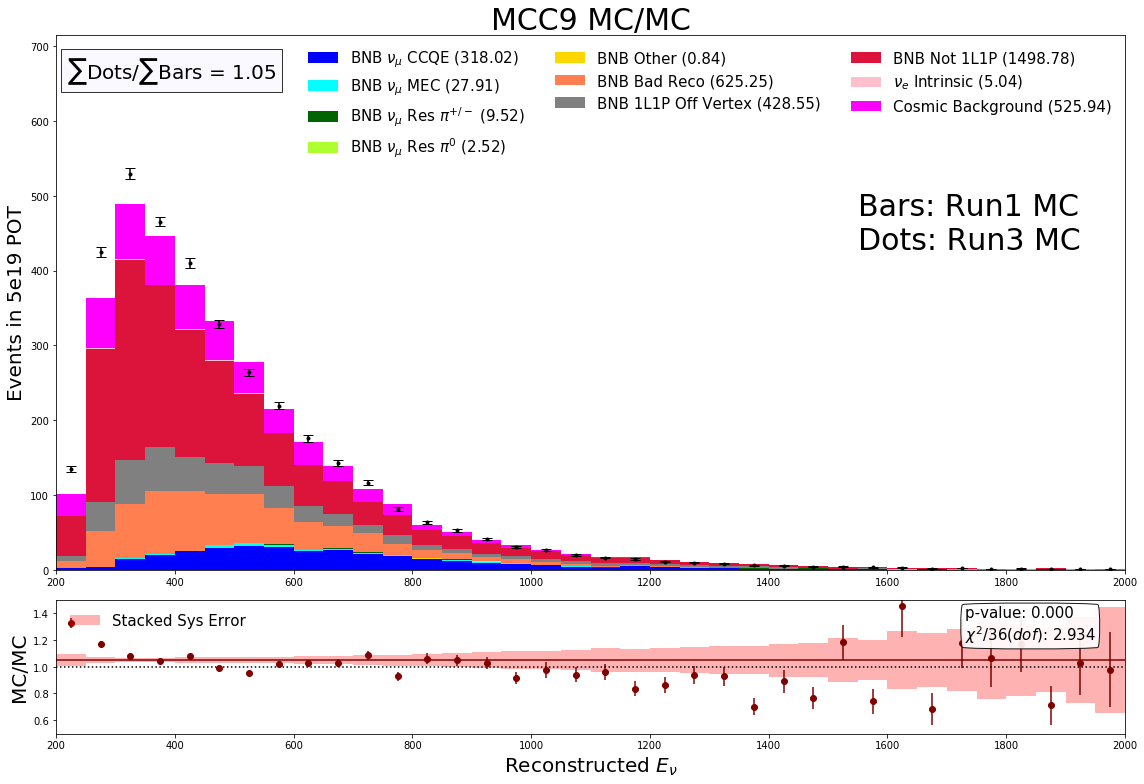

In [9]:
# distplot_wratio(string of variable name, number of bins, range, stacked histo list, data list, name for x-axis)
# for other arguments, see PlottingScripts.py

vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (200,2000)

fig,ax0 = mcmcplot(vartest,nbins,myrange,run1Hists,run3Hists,varname,normshift=1.05)
ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


Text(0.75, 0.6, 'Bars: Run1 MC\nDots: Run3 MC')

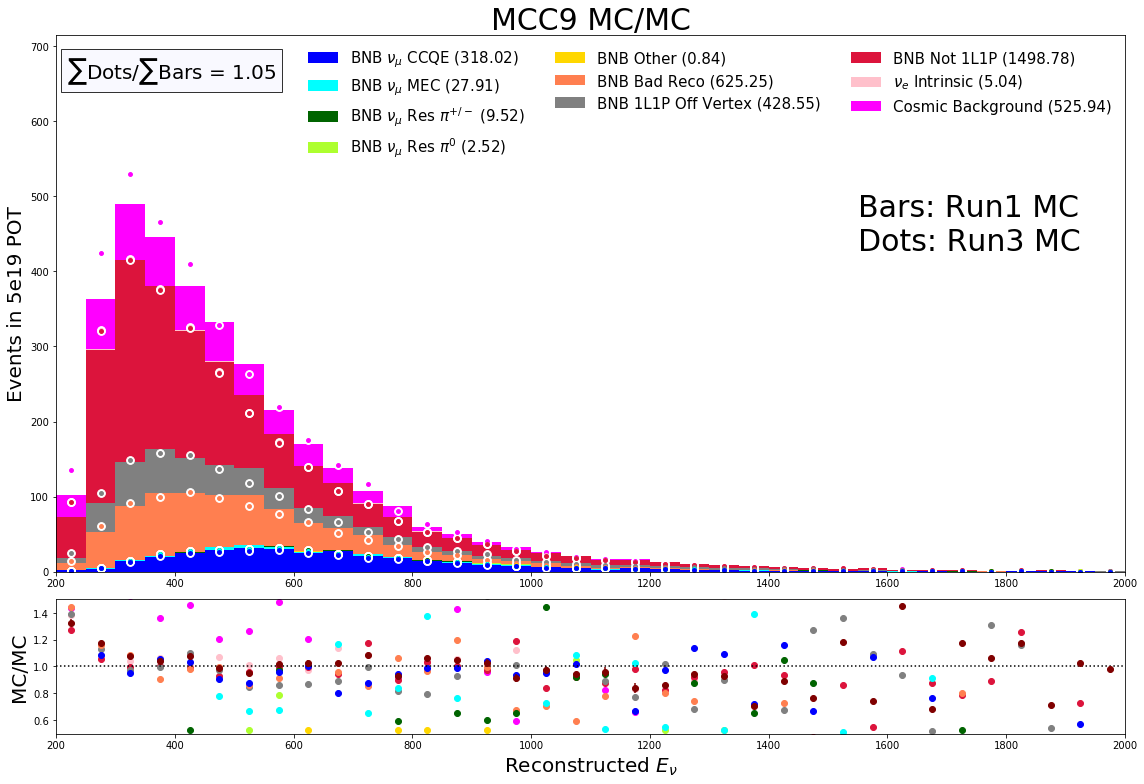

In [10]:
# distplot_wratio(string of variable name, number of bins, range, stacked histo list, data list, name for x-axis)
# for other arguments, see PlottingScripts.py

vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (200,2000)

fig,ax0 = mcmcplot_finegrain(vartest,nbins,myrange,run1Hists,run3Hists,varname)
ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide


Text(0.75, 0.6, 'Bars: Run1 MC\nDots: Run3 MC')

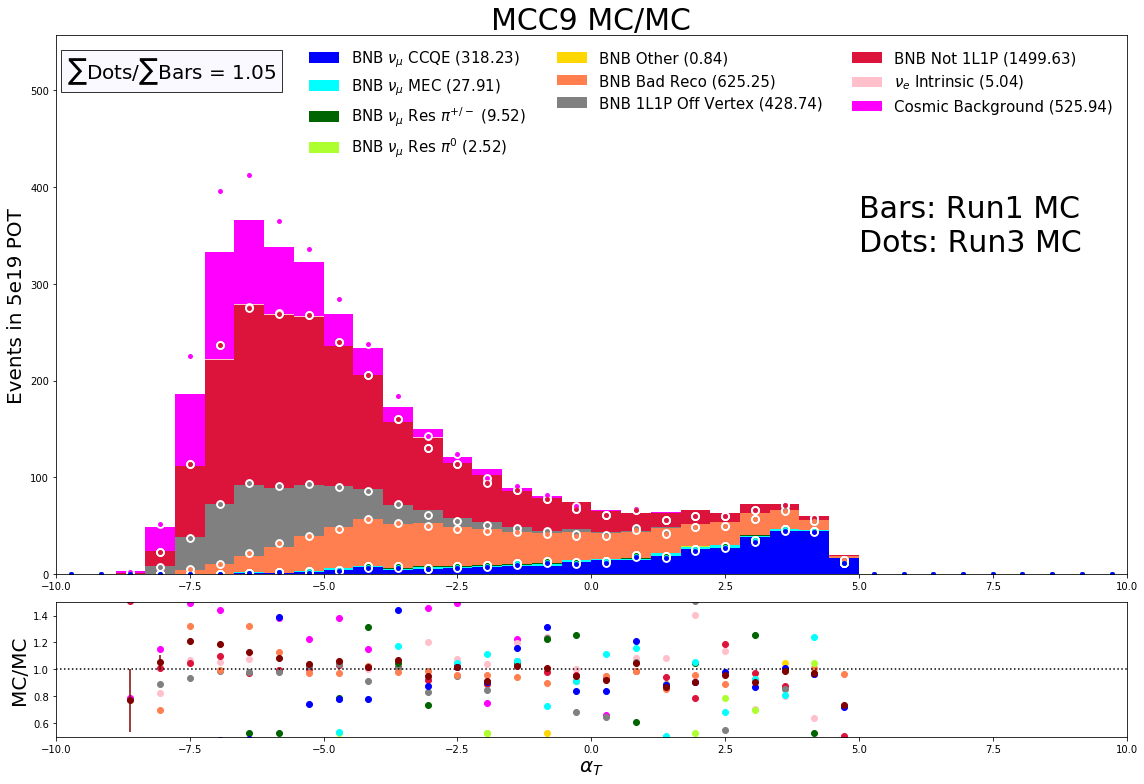

In [156]:
vartest = 'BDTscore_1mu1p_cosmic'
varname = r'$\alpha_T$'
myrange = (-10,10)

fig,ax0 = mcmcplot_finegrain(vartest,nbins,myrange,run1Hists,run3Hists,varname)
ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)

In [17]:
# Make big list of variables with their accompanying ranges so we can just dump a buttload of plots
varlist = []

varlist.append(distVar('BDTscore_1mu1p_cosmic',(-10,5),'Cosmic BDT Score'))
varlist.append(distVar('BDTscore_1mu1p_nu',(-8,2.5),'Nu BDT Score'))
varlist.append(distVar('Xreco',(15,241.25),'Reco Vertex X','../data/CovMatrices_Apr20/covar_postsel__x_reco.txt'))
varlist.append(distVar('Yreco',(-101.5,101.5),'Reco Vertex Y','../data/CovMatrices_Apr20/covar_postsel__y_reco.txt'))
varlist.append(distVar('Zreco',(15,1021.8),'Reco Vertex Z','../data/CovMatrices_Apr20/covar_postsel__z_reco.txt'))
#varlist.append(distVar('Good3DReco',(0,1),'Good 3D Reco (tracker metric)'))
varlist.append(distVar('Eta',(0,.8),r'$\eta$'))
varlist.append(distVar('OpenAng',(.5,np.pi),'Opening Angle (rads)','../data/CovMatrices_Apr20/covar_postsel__openang_reco.txt'))
varlist.append(distVar('Thetas',(0,2*np.pi),r'Sum of Thetas ($\theta_{p} + \theta_{\mu}$) (rads)'))
varlist.append(distVar('Phis',(0,2*np.pi),r'Sum of Phis ($\phi_{p} + \phi_{\mu}$)  (rads)'))
varlist.append(distVar('ChargeNearTrunk',(0,800),'ADC Charge within 5cm of Reco Vertex'))
varlist.append(distVar('CCQEEnergyShift_1m1p',(0,5),'Energy Shift (in MeV) to Maximize QE Consistency'))
varlist.append(distVar('Enu_1m1p',(200,2000),'Reconstructed Neutrino Energy (MeV)','../data/CovMatrices_Apr20/covar_postsel__nu_energy_reco.txt'))
varlist.append(distVar('PhiT_1m1p',(0,np.pi),r'$\phi_T$'))
varlist.append(distVar('AlphaT_1m1p',(0,np.pi),r'$\alpha_T$','../data/CovMatrices_Apr20/covar_postsel__alphaT_reco.txt'))
varlist.append(distVar('PT_1m1p',(0,850),r'$p_T$','../data/CovMatrices_Apr20/covar_postsel__pT_reco.txt'))
varlist.append(distVar('PTRat_1m1p',(0,1),r'$p_T/|p|$','../data/CovMatrices_Apr20/covar_postsel__pT_ratio_reco.txt'))
varlist.append(distVar('BjX_1m1p',(0,2),'Bjorken X','../data/CovMatrices_Apr20/covar_postsel__Bjx_reco.txt'))
varlist.append(distVar('BjY_1m1p',(0,1),'Bjorken Y','../data/CovMatrices_Apr20/covar_postsel__Bjy_reco.txt'))
varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
varlist.append(distVar('Sph_1m1p',(0,4000),'QE Consistency'))
varlist.append(distVar('PzEnu_1m1p',(-1500,400),r'$p_z - E_\nu$ (MeV)'))
varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))
varlist.append(distVar('Lepton_PhiReco',(-np.pi,np.pi),r'Muon $\phi$','../data/CovMatrices_Apr20/covar_postsel__lepton_phi_reco.txt'))
varlist.append(distVar('Lepton_ThetaReco',(0,np.pi),r'Muon $\theta$','../data/CovMatrices_Apr20/covar_postsel__lepton_theta_reco.txt'))
varlist.append(distVar('Lepton_TrackLength',(5,200),'Muon Track Length (cm)','../data/CovMatrices_Apr20/covar_postsel__lepton_length_reco.txt'))
varlist.append(distVar('Muon_Edep',(20,600),'Reco Muon Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__lepton_KE_reco.txt'))
varlist.append(distVar('Proton_PhiReco',(-np.pi,np.pi),r'Proton $\phi$','../data/CovMatrices_Apr20/covar_postsel__proton_phi_reco.txt'))
varlist.append(distVar('Proton_ThetaReco',(0,np.pi),r'Proton $\theta$','../data/CovMatrices_Apr20/covar_postsel__proton_theta_reco.txt'))
varlist.append(distVar('Proton_TrackLength',(5,150),'Proton Track Length','../data/CovMatrices_Apr20/covar_postsel__proton_length_reco.txt'))
varlist.append(distVar('Proton_Edep',(50,500),'Reco Proton Energy (from range) (MeV)','../data/CovMatrices_Apr20/covar_postsel__proton_KE_reco.txt'))


In [158]:


dumpbins = 36
dumphole = 'MCMC_May1' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlist:
    fig,ax0 = mcmcplot(dist.myname,dumpbins,dist.myrange,run1Hists,run3Hists,dist.mylabel,normshift=1.05)
    ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)
    plt.savefig(dumphole+'/'+dist.myname+'_mcmc.png')
    plt.close(fig)
    
    fig,ax0 = mcmcplot_finegrain(dist.myname,dumpbins,dist.myrange,run1Hists,run3Hists,dist.mylabel)
    ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)
    plt.savefig(dumphole+'/'+dist.myname+'_mcmc_finegrained.png')
    plt.close(fig)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84

# Apply cuts

In [11]:
bdtcuts = 'BDTscore_1mu1p_cosmic > 0 and BDTscore_1mu1p_nu > 0'

s_cuts = bdtcuts

s_ano_simple_w = wrap('Precuts and '+s_cuts,28)
s_ano_simple = '' 
for ln in s_ano_simple_w:
    s_ano_simple += ln + '\n'

In [12]:
run1HistsSel = []
run3HistsSel = []

for i in range(len(run1Hists)):
    run1HistsSel.append(run1Hists[i].applycut(s_cuts))

for i in range(len(run3Hists)):
    run3HistsSel.append(run3Hists[i].applycut(s_cuts))

nbins = 18

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide


Text(0.75, 0.6, 'Bars: Run1 MC\nDots: Run3 MC')

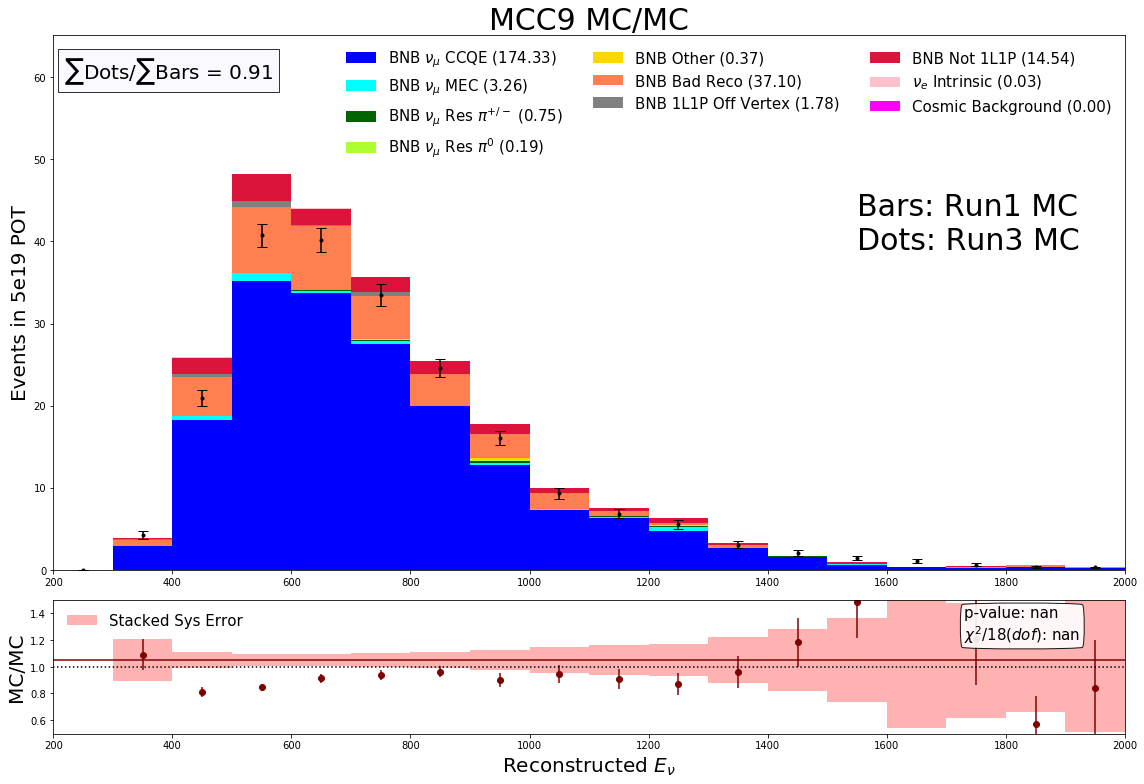

In [13]:
# distplot_wratio(string of variable name, number of bins, range, stacked histo list, data list, name for x-axis)
# for other arguments, see PlottingScripts.py

vartest = 'Enu_1m1p'
varname = r'Reconstructed $E_\nu$'
myrange = (200,2000)

fig,ax0 = mcmcplot(vartest,nbins,myrange,run1HistsSel,run3HistsSel,varname,normshift=1.05)
ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)

18
Events: 162.0
Min Bin ct (data): 4.0


Text(0.75, 0.6, 'Precuts and CosmicBkgScore >\n0 and NuBkgScore > 0\n')

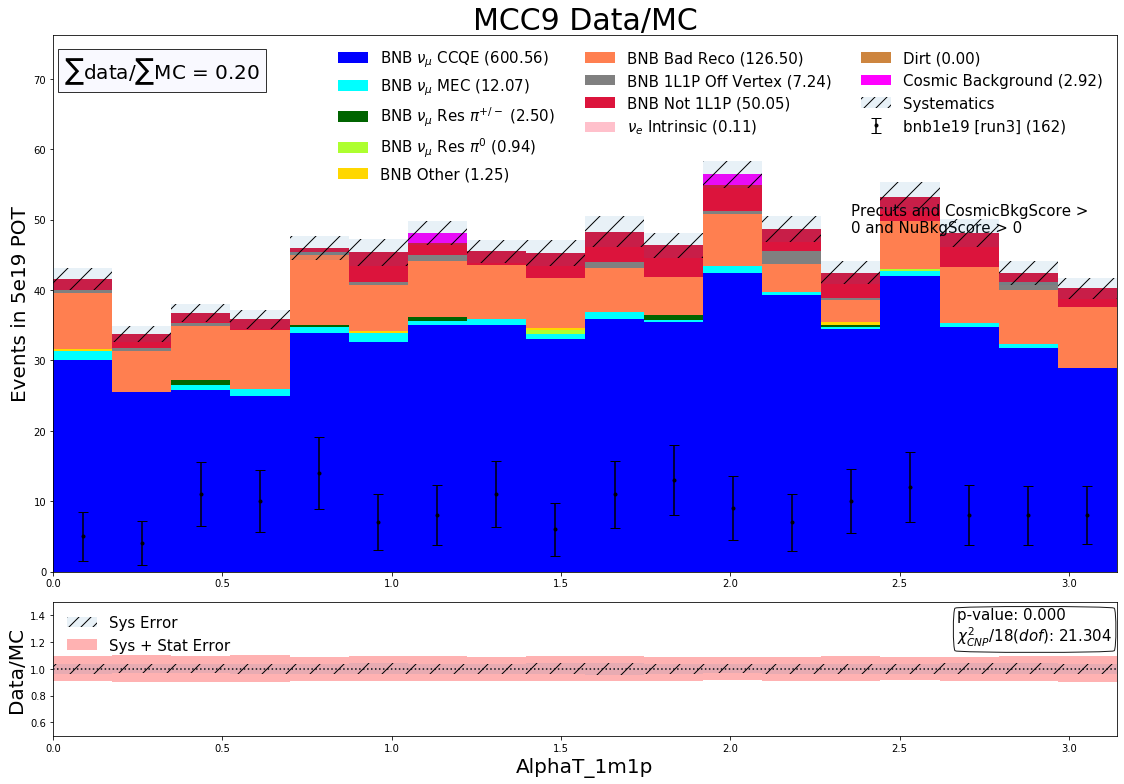

In [17]:
vartest = 'AlphaT_1m1p'
varname = vartest
myrange = (0,np.pi)
scov = '../data/CovMatrices_Apr20/covar_postsel__alphaT_reco.txt'
legpos = 0

fig,ax0 = distplot_wratio(vartest,nbins,myrange,sampleHistsSel,run3HistSel,varname,s_cov=scov)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Events: 217.0
Min Bin ct (data): 0.0


Text(0.75, 0.6, 'Precuts and CosmicBkgScore >\n0 and NuBkgScore > 0\n')

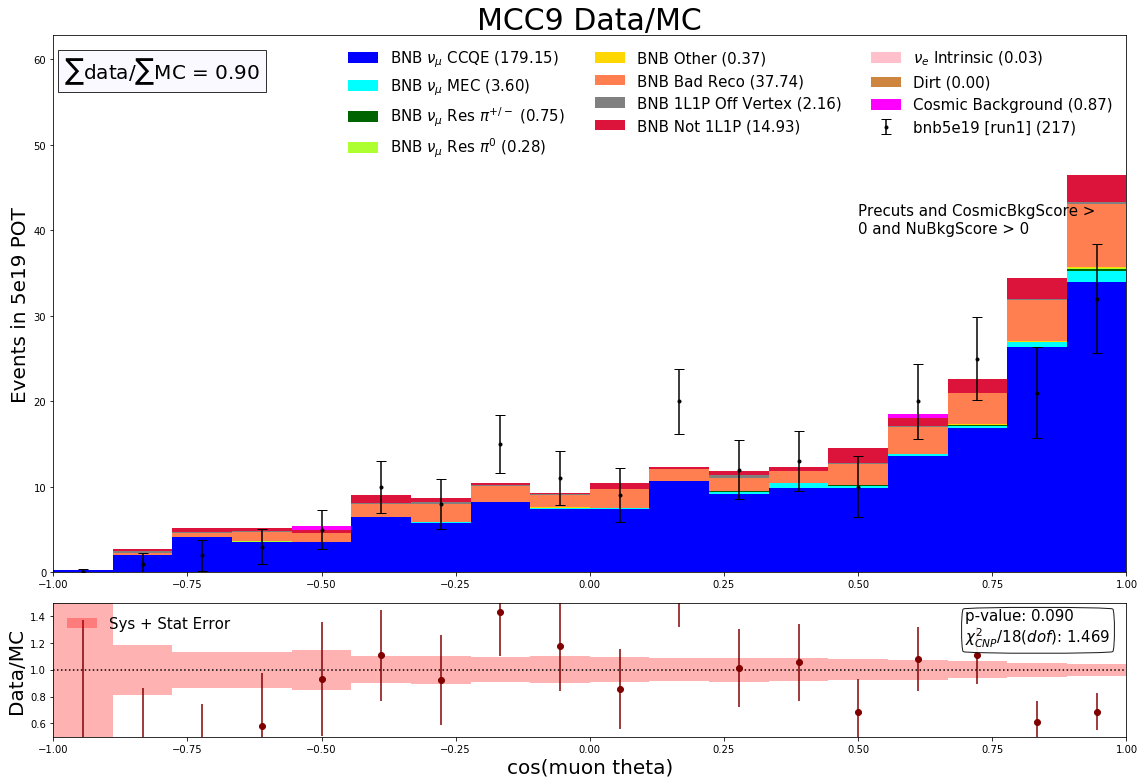

In [32]:
vartest = 'Lepton_CosTheta'
varname = 'cos(muon theta)'
myrange = (-1,1)
scov = '../data/CovMatrices_Apr20/covar_postsel__alphaT_reco.txt'
legpos = 0

fig,ax0 = distplot_wratio(vartest,nbins,myrange,sampleHistsSel,run1HistSel,varname)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)

Events: 217.0
Min Bin ct (data): 2.0


Text(0.75, 0.6, 'Precuts and CosmicBkgScore >\n0 and NuBkgScore > 0\n')

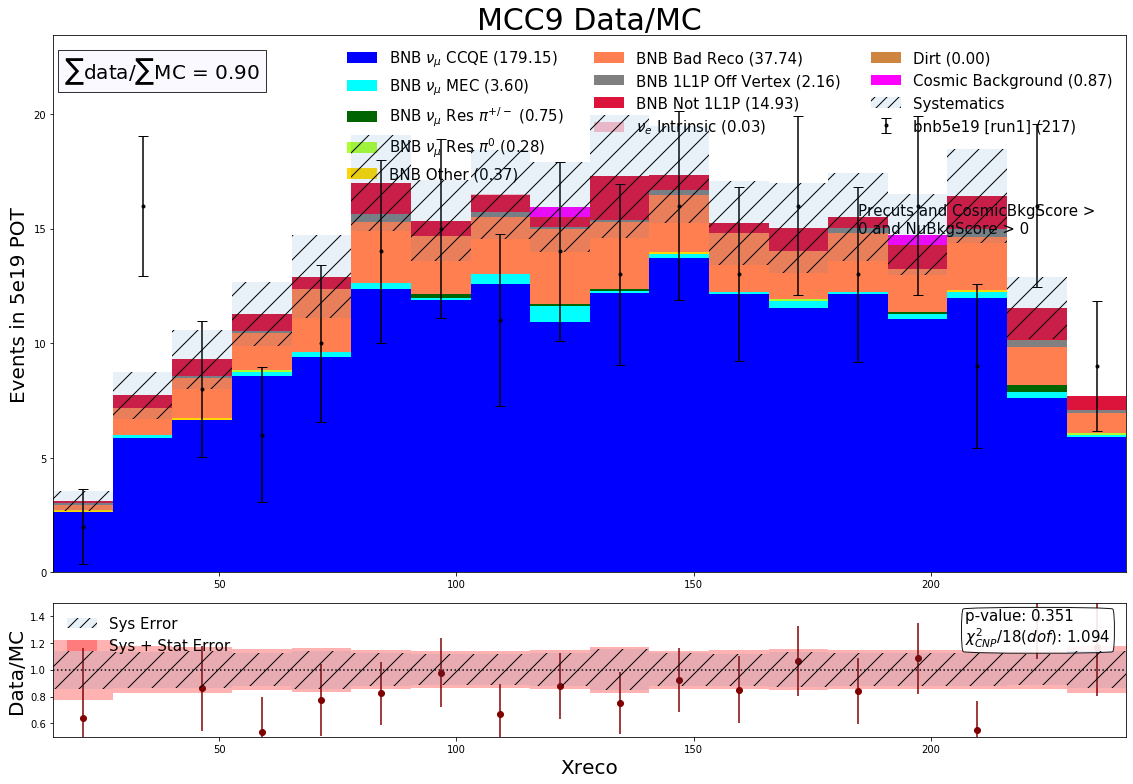

In [21]:
vartest = 'Xreco'
varname = vartest
myrange = (15,241.25)
scov = '../data/CovMatrices_Apr20/covar_postsel__x_reco.txt'
legpos = 0

fig,ax0 = distplot_wratio(vartest,nbins,myrange,sampleHistsSel,run1HistSel,varname,s_cov=scov)
ax0.annotate(s_ano_simple,xy=(.75,.6), xycoords='axes fraction',fontsize=15)

In [18]:
dumpbins = 18
dumphole = 'MCMC_May1_sel' # where are we dumping these?

if not os.path.exists(dumphole):
    os.makedirs(dumphole)

for dist in varlist:
    fig,ax0 = mcmcplot(dist.myname,dumpbins,dist.myrange,run1HistsSel,run3HistsSel,dist.mylabel,normshift=1.05)
    ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)
    plt.savefig(dumphole+'/'+dist.myname+'_mcmc.png')
    plt.close(fig)
    
    fig,ax0 = mcmcplot_finegrain(dist.myname,dumpbins,dist.myrange,run1HistsSel,run3HistsSel,dist.mylabel)
    ax0.annotate('Bars: Run1 MC\nDots: Run3 MC',xy=(.75,.6), xycoords='axes fraction',fontsize=30)
    plt.savefig(dumphole+'/'+dist.myname+'_mcmc_finegrained.png')
    plt.close(fig)

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:84: RuntimeWarning: divide by zero encountered in true_divide


In [11]:
# Print RSE for lauren

selvars = ['run','subrun','event','Xreco','Yreco','Zreco','Eta','OpenAng','Thetas','Phis','ChargeNearTrunk','Enu_1m1p','PhiT_1m1p','AlphaT_1m1p','PT_1m1p','PTRat_1m1p','BjX_1m1p','BjY_1m1p','Q2_1m1p','Sph_1m1p','Q0_1m1p','Q3_1m1p','Lepton_PhiReco','Lepton_ThetaReco','Lepton_TrackLength','Muon_Edep','Lepton_CosTheta','Proton_PhiReco','Proton_ThetaReco','Proton_TrackLength','Proton_Edep','Proton_CosTheta']

simpleHistsSel[0]._df[selvars].to_csv('~/Downloads/bnb-postsel_forlauren-apr27.txt',index=False)
simpleHistsSel[1]._df[selvars].to_csv('~/Downloads/nue-postsel_forlauren-apr27.txt',index=False)
simpleHistsSel[2]._df[selvars].to_csv('~/Downloads/dirt-postsel_forlauren-apr27.txt',index=False)
simpleHistsSel[3]._df[selvars].to_csv('~/Downloads/ext-postsel_forlauren-apr27.txt',index=False)

In [ ]:
var1 = 'Xreco'
var2 = 'TotPE'
#ext_var1 = (df_ext_sel[var1].values)
#ext_var2 = (df_ext_sel[var2].values)

#numu_var1 = (df_numu_CCQE_sel[var1].values)
#numu_var2 = (df_numu_CCQE_sel[var2].values)

ext_var1 = (df_data_presel[var1].values)
ext_var2 = (df_data_presel[var2].values)

numu_var1 = (df_numu_CCQE_presel[var1].values)
numu_var2 = (df_numu_CCQE_presel[var2].values)

print(numu_var2.max())

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
sns.kdeplot(numu_var1,numu_var2,label='numu CCQE MC',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='data',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='upper right')
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(0,256)
plt.ylim(0,2000)

x0 = np.linspace(0,6)
y0 = -(x0)*300+250
y1 = (x0-2.6)*600

#plt.plot(x0,y0,c='coral')
#plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

In [26]:
df_numu_total = pd.read_parquet('../data/pickles/numu_nodupes_%s.parquet'%tag).query("mc_label in ['numu_CCQE']")

with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_WC_apr1.pickle','rb') as handle: cosmicBDT,nubkgBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
    
vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']

myvars = vars_cos_allofem
s_nubdtname = 'NuBkgScore'
s_cosbdtname = 'CosmicBkgScore'
for i in range(len(sampleHists)):
    df_numu_total.insert(0,s_nubdtname,nubkgBDT.predict(df_numu_total[myvars].values.tolist(),output_margin=True))
    df_numu_total.insert(0,s_cosbdtname,cosmicBDT.predict(df_numu_total[myvars].values.tolist(),output_margin=True))
 

ValueError: cannot insert NuBkgScore, already exists

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


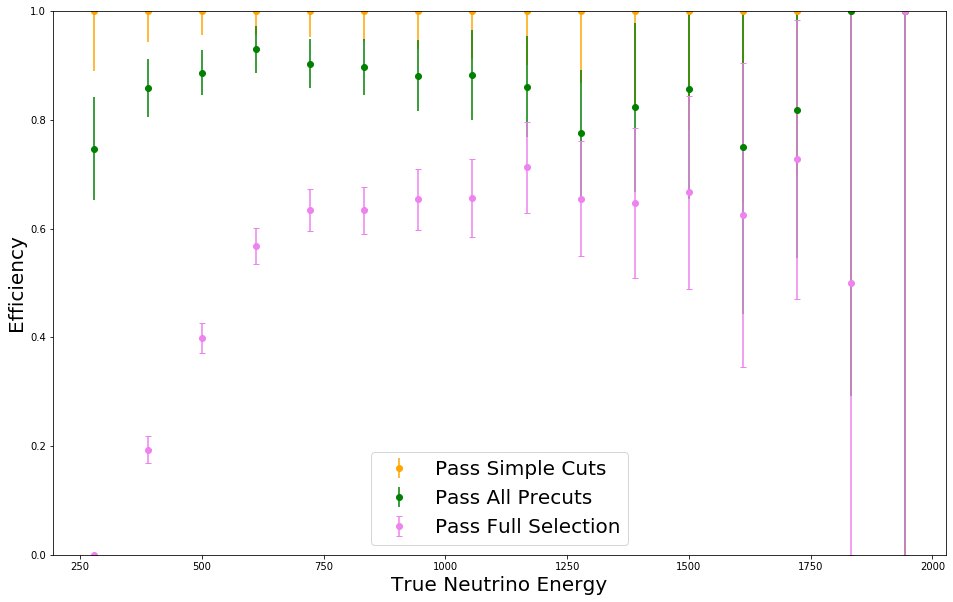

In [35]:
nbins = 18
myrange=(0,2000)
vartest = 'MC_energyInit'

orthogonalcut = 'MaxShrFrac < .2'
precuts = 'OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
coscut = 'CosmicBkgScore > 0'
nucut = 'NuBkgScore > 0'

#varlist.append(distVar('Q2_1m1p',(0,6e5),r'$Q^2$','../data/CovMatrices_Apr20/covar_postsel__Q2_reco.txt'))
#varlist.append(distVar('Q0_1m1p',(70,600),r'$Q_0$','../data/CovMatrices_Apr20/covar_postsel__Q0_reco.txt'))
#varlist.append(distVar('Q3_1m1p',(50,1000),r'$Q_3$','../data/CovMatrices_Apr20/covar_postsel__Q3_reco.txt'))



val_total,binedges = np.histogram(df_numu_total[vartest].values,bins=nbins,range=myrange)
bincenters = np.diff(binedges)/2 + binedges[:-1]

fig,ax = plt.subplots(figsize=(16,10))

val1_cut,_ = np.histogram(df_numu_total.query('PassSimpleCuts == 1')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val1_cut,val_total),label='Pass Simple Cuts',yerr=np.sqrt(val1_cut)/val_total,fmt='o',c='orange')

val2_cut,_ = np.histogram(df_numu_total.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val2_cut,val_total),label='Pass All Precuts',yerr=np.sqrt(val2_cut)/val_total,fmt='o',c='green')

val4_cut,_ = np.histogram(df_numu_total.query('PassSimpleCuts == 1 and MaxShrFrac < .2 and OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15 and CosmicBkgScore > 0 and NuBkgScore > 0')[vartest].values,bins=nbins,range=myrange)
ax.errorbar(bincenters,np.divide(val4_cut,val_total),label='Pass Full Selection',yerr=np.sqrt(val4_cut)/val_total,fmt='o',c='violet',capsize=3)


ax.set_ylim(0,1)
    
ax.set_xlabel(r'True Neutrino Energy',fontsize=20)
ax.set_ylabel('Efficiency',fontsize=20)
ax.legend(fontsize=20)

## mostly experimental  2d  plots

(0, 3.141592653589793)

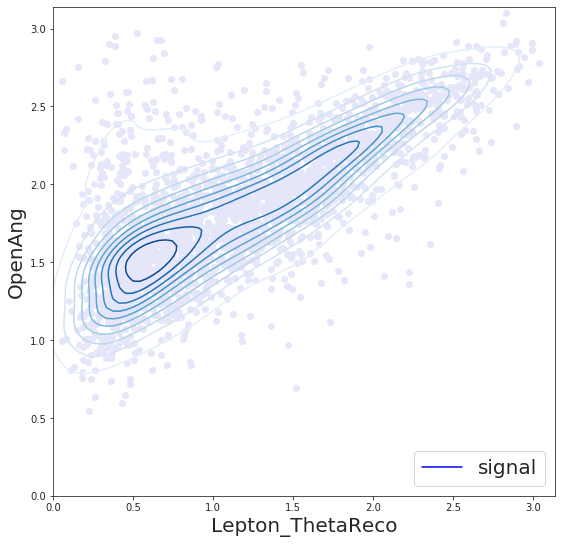

In [43]:
df_sig = sampleHists[0]._df
#df_bkg = df_numu_presel.query("mc_label not in ['numu_CCQE']")
#df_nubkg = df_numu_presel.query("mc_label not in ['numu_CCQE'] or not "+goodreco+' or MC_nproton!=1 or MC_nlepton!=1')

#with open('/home/dcianci/Physics/1e1p/1mu1pSelection/bdtweights_1mu1p_WC_mar26-deepcuts.pickle','rb') as handle: cosmicBDT,nuBDT = pickle.load(handle)          # Load BDT weights for 1mu1p background differentiation
#vars_cos_allofem = ['Eta','ChargeNearTrunk','PT_1m1p','PhiT_1m1p','AlphaT_1m1p','Sph_1m1p','Q0_1m1p','Q2_1m1p','Q3_1m1p','Lepton_ThetaReco','Lepton_PhiReco','Proton_ThetaReco','Proton_PhiReco','PTRat_1m1p','Lepton_TrackLength','Thetas','Phis','Proton_TrackLength','OpenAng','PzEnu_1m1p']
#myvars = vars_cos_allofem
#df_sig.insert(0,'NuBkgScore1',nuBDT.predict(df_nusignal[myvars].values.tolist(),output_margin=True))
#df_bkg.insert(0,'NuBkgScore1',nuBDT.predict(df_extbkg[myvars].values.tolist(),output_margin=True))
#df_nubkg.insert(0,'NuBkgScore1',nuBDT.predict(df_nubkg[myvars].values.tolist(),output_margin=True))


var1 = 'Lepton_ThetaReco'
var2 = 'OpenAng'

sig_var1 = df_sig[var1].values
sig_var2 = df_sig[var2].values

bkg1_var1 = df_bkg[var1].values
bkg1_var2 = df_bkg[var2].values


fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
#plt.scatter(bkg1_var1,bkg1_var2,color='mistyrose',alpha=.9)
#plt.scatter(bkg2_var1,bkg2_var2,color='honeydew',alpha=.9)
plt.scatter(sig_var1,sig_var2,color='lavender',alpha=1)


#sns.kdeplot(bkg1_var1,bkg1_var2,label='bkg',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
#sns.kdeplot(bkg2_var1,bkg2_var2,label='nubkg',color='green',cmap='Greens')#,cmap="Reds", shade=True, bw=.15)
sns.kdeplot(sig_var1,sig_var2,label='signal',color='blue',cmap='Blues')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
plt.xlim(0,np.pi)
plt.ylim(0,np.pi)

In [34]:
var1 = 'Muon_ThetaReco'
var2 = 'OpenAng'
#ext_var1 = (df_ext_sel[var1].values)
#ext_var2 = (df_ext_sel[var2].values)

#numu_var1 = (df_numu_CCQE_sel[var1].values)
#numu_var2 = (df_numu_CCQE_sel[var2].values)

ext_var1 = (df_data_presel[var1].values)
ext_var2 = (df_data_presel[var2].values)

numu_var1 = (df_numu_CCQE_presel[var1].values)
numu_var2 = (df_numu_CCQE_presel[var2].values)

fig,ax = plt.subplots(figsize=(9,9))
sns.set_style('ticks')
plt.scatter(ext_var1,ext_var2,color='mistyrose',alpha=.9)
plt.scatter(numu_var1,numu_var2,color='lavender',alpha=1)
sns.kdeplot(numu_var1,numu_var2,label='ccqe',color='blue',cmap='Blues')#,cmap="Greens", shade=True, bw=.15)
sns.kdeplot(ext_var1,ext_var2,label='ext',color='red',cmap='Reds')#,cmap="Reds", shade=True, bw=.15)

ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)
plt.legend(fontsize=20,loc='lower right')
#plt.yscale('log')
#plt.xscale('log')
#plt.xlim(0,np.pi)
#plt.ylim(-2000,1000)

x0 = np.linspace(0,6)
y0 = (x0-2)*100
y1 = (x0-2.6)*600

plt.plot(x0,y0,c='coral')
#plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

NameError: name 'df_data_presel' is not defined

/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/dcianci/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less


[2. 4. 2. 8. 4. 2. 1. 0. 1. 1. 3. 1. 0. 2. 0. 1. 2. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [inf inf inf inf inf inf inf nan inf inf inf inf nan inf nan inf inf nan
 nan nan]


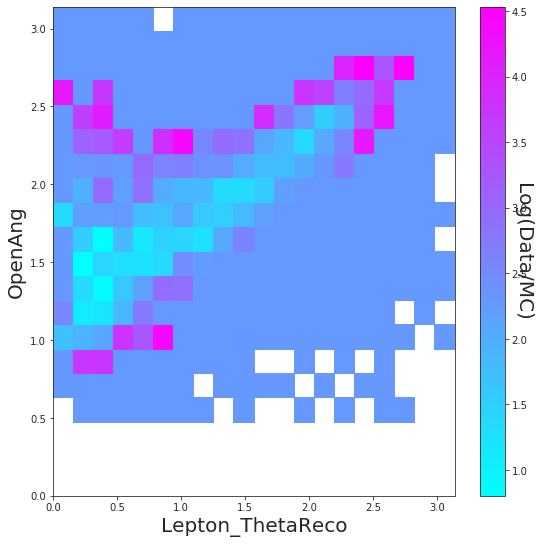

In [85]:
var1 = 'Lepton_ThetaReco'
var2 = 'OpenAng'

nbins1 = 20
nbins2 = 20
range1 = (0,np.pi)
range2 = (0,np.pi)

h_obs = run1Hist
hlist_pred = sampleHistsSel

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hobs, xedges, yedges = np.histogram2d(h_obs.dist(var1),h_obs.dist(var2),[nbins1,nbins2],[range1,range2],weights=h_obs._wgt*h_obs._scale)
Hpred = np.zeros((nbins1,nbins2))
for hist in hlist_pred:
    h0,_,_ = np.histogram2d(hist.dist(var1),hist.dist(var2),[nbins1,nbins2],[range1,range2],weights=hist._wgt*hist._scale)
    Hpred += h0
    
Hobs = Hobs.T
Hpred = Hpred.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hobs,Hpred)

print(Hobs[4],Hpred[4],Hrat[4])

Hrat[Hrat>100] = 10
Hrat[Hrat<0] = .000001


crat = ax.pcolormesh(X, Y,np.log(Hrat),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('Log(Data/MC)', rotation=270,fontsize=20)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)

y0 = (x0-1.8)*100
y1 = (x0-2.5)*250

#plt.plot(x0,y0,c='coral')
#plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

In [ ]:
var1 = 'Enu_1m1p'
var2 = 'MC_energyInit'

nbins1 = 50
nbins2 = 50
range1 = (0,3000)
range2 = (0,3000)

df_sig = df_numu_presel.query("mc_label in ['nLmP','offvtx','badreco']")
df_bkg = df_numu_presel.query("mc_label in ['numu_CCQE']")

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hsig, xedges, yedges = np.histogram2d(df_sig[var1],df_sig[var2],[nbins1,nbins2],[range1,range2],density=1)
Hbkg, _,_ = np.histogram2d(df_bkg[var1],df_bkg[var2],[nbins1,nbins2],[range1,range2],density=1)
Hsig = Hsig.T
Hbkg = Hbkg.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hsig,Hbkg)

Hrat[Hrat<1] = .000001

crat = ax.pcolormesh(X, Y, np.log10(Hrat),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('log(signal/background)', rotation=270,fontsize=10)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)


y0 = -(x0)*300+250
y1 = (x0-2.6)*600



plt.plot(x0,y0,c='coral')
plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

In [ ]:
var1 = 'Thetas'
var2 = 'ChargeNearTrunk'

nbins1 = 20
nbins2 = 20
range1 = (0,3)
range2 = (0,1000)

df_sig = df_numu_CCQE_presel
df_bkg = df_bnb_offvtx_presel#df_ext_presel

fig,ax = plt.subplots(figsize=(9,9))
ax.set_xlabel(var1,fontsize=20)
ax.set_ylabel(var2,fontsize=20)

Hsig, xedges, yedges = np.histogram2d(df_sig[var1],df_sig[var2],[nbins1,nbins2],[range1,range2],weights=weights_numu_CCQE_presel,density=1)
Hbkg, _,_ = np.histogram2d(df_bkg[var1],df_bkg[var2],[nbins1,nbins2],[range1,range2],weights=weights_bnb_offvtx_presel,density=1)
Hsig = Hsig.T
Hbkg = Hbkg.T
X, Y = np.meshgrid(xedges, yedges)

Hrat = np.true_divide(Hsig,Hbkg)

Hrat[Hrat<1] = .000001

crat = ax.pcolormesh(X, Y, np.log10(Hrat),cmap='cool')
cbar = fig.colorbar(crat)
cbar.ax.set_ylabel('log(signal/background)', rotation=270,fontsize=10)

plt.xlim(range1)
plt.ylim(range2)
x0 = np.linspace(0,6)


y0 = -(x0)*300+250
y1 = (x0-2.6)*600



plt.plot(x0,y0,c='coral')
plt.plot(x0,y1,c='orange')
#ax.axvline(2.8)

In [ ]:
tag = 'Apr20-WiremodTest_run3'

orthogonalcut = 'MaxShrFrac < .2'
precuts ='OpenAng > .5 and ChargeNearTrunk > 0 and FailedBoost != 1 and Lepton_EdgeDist > 15 and Proton_EdgeDist > 15'
emptycut = 'Enu_1m1p > 0'

precut = orthogonalcut + ' and ' + precuts

df_numu_presel = pd.read_parquet('../data/pickles/numu_goodruns_precuts_%s.parquet'%tag).query(precut)

In [ ]:
sampleHists = []
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_CCQE']"),r'BNB $\nu_\mu$ CCQE','blue',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_MEC']"),r'BNB $\nu_\mu$ MEC','cyan',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_piplusminus']"),r'BNB $\nu_\mu$ Res $\pi^{+/-}$','darkgreen',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_pizero']"),r'BNB $\nu_\mu$ Res $\pi^{0}$','greenyellow',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['numu_other','BNB nue_other','nue_MEC','nue_piplusminus','nue_pizero']"),r'BNB Other','gold',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['badreco']"),r'BNB Bad Reco','coral',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['offvtx']"),r'BNB 1L1P Off Vertex','grey',1,NUMU_SCALE))
sampleHists.append(sampHist(df_numu_presel.query("mc_label in ['nLmP']"),r'BNB Not 1L1P','crimson',1,NUMU_SCALE))

In [ ]:
list(df_numu_presel)

In [ ]:
# distplot_wratio(string of variable name, number of bins, range, stacked histo list, data list, name for x-axis)
# for other arguments, see PlottingScripts.py

vartest = 'BDTscore_1mu1p_nu'
varname = vartest
myrange = (-10,10)
nbins =36

fig,ax0 = distplot_wratio(vartest,nbins,myrange,sampleHists,sampleHists[0],varname,normshift=.96)